# Hours Prediction

In [1]:
import pandas as pd
from collections import defaultdict
import math
import numpy as np
from progressbar import progressbar
import gzip

In [2]:
def readJSON(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        d = eval(l)
        u = d['userID']
        g = d['gameID']
        yield u,g,d

allHours = []
for l in readJSON("data/train.json.gz"):
    allHours.append(l)

In [3]:
items = []
users = []
hours = []

for user, item, d in allHours:
    items.append(item)
    users.append(user)
    hours.append(d['hours_transformed'])

hoursTrainUsers = users[:165000]
hoursTrainItems = items[:165000]
hoursTrainHours = hours[:165000]

hoursValidUsers = users[165000:]
hoursValidItems = items[165000:]
hoursValidHours = hours[165000:]

In [4]:
# calculate averaged play time for each user
def get_userAverage(users, hours):
    temp = defaultdict(list)
    for user, hour in zip(users, hours):
        temp[user].append(hour)
    
    userAverage = {}
    for user in temp:
        userAverage[user] = float(sum(temp[user]) / len(temp[user]))
    
    return userAverage


def get_itemAverage(items, hours):
    temp = defaultdict(list)
    for item, hour in zip(items, hours):
        temp[item].append(hour)
    
    itemAverage = {}
    for item in temp:
        itemAverage[item] = float(sum(temp[item]) / len(temp[item]))
    
    return itemAverage


def MSE(preds, truth_vals):
    assert len(preds) == len(truth_vals)
    temp = [(x-y)**2 for x, y in zip(preds, truth_vals)]
    return sum(temp) / len(temp)

In [5]:
# the following two variables will be used when users/items do not appear in the training set
globalAverage = float(sum(hoursTrainHours) / len(hoursTrainHours))
userAverage = get_userAverage(hoursTrainUsers, hoursTrainHours)
itemAverage = get_itemAverage(hoursTrainItems, hoursTrainHours)

In [6]:
hoursPerUser = defaultdict(list)
hoursPerItem = defaultdict(list)
itemsPerUser = defaultdict(set)
usersPerItem = defaultdict(set)

for user, item, hour in zip(hoursTrainUsers, hoursTrainItems, hoursTrainHours):
    hoursPerUser[user].append(hour)
    hoursPerItem[item].append(hour)
    itemsPerUser[user].add(item)
    usersPerItem[item].add(user)

In [7]:
ibetaU = {}
ibetaI = {}
for u in hoursPerUser:
    ibetaU[u] = np.random.normal(loc = 0.0, scale = 0.1)

for g in hoursPerItem:
    ibetaI[g] = np.random.normal(loc = 0.0, scale = 0.1)

ialpha = globalAverage # Could initialize anywhere, this is a guess

hourDict = {}
for user, item, hour in zip(hoursTrainUsers, hoursTrainItems, hoursTrainHours):
    hourDict[(user, item)] = hour
Ntrain = len(hourDict)

def update_once(oldAlpha, oldBetaU, oldBetaI, lambU, lambI):
    # update data alpha
    temp = 0
    for user, game in hourDict:
        Rui = hourDict[(user, game)]
        bu = oldBetaU[user]
        bi = oldBetaI[game]
        temp += (Rui - (bu + bi))
    newAlpha = temp / Ntrain
    
    # update betaU
    newBetaU = {}
    for user in oldBetaU:
        temp = 0
        items = itemsPerUser[user]
        for item in items:
            Rui = hourDict[(user, item)]
            bi = oldBetaI[item]
            temp += (Rui - (newAlpha + bi))
        newBetaU[user] = temp / (lambU + len(items))
    
    # update betaI
    newBetaI = {}
    for item in oldBetaI:
        temp = 0
        users = usersPerItem[item]
        for user in users:
            Rui = hourDict[(user, item)]
            bu = newBetaU[user]
            temp += (Rui - (newAlpha + bu))
        newBetaI[item] = temp / (lambI + len(users))
    
    return newAlpha, newBetaU, newBetaI

def iterate(lambU, lambI, niter, init_alpha, init_betaU, init_betaI):
    alpha, betaU, betaI = update_once(init_alpha, init_betaU, init_betaI, lambU, lambI)
    for _ in progressbar( range(niter - 1) ):
        alpha, betaU, betaI = update_once(alpha, betaU, betaI, lambU, lambI)
    return alpha, betaU, betaI

In [8]:
fit_alpha, fit_betaU, fit_betaI = iterate(9.84, 2.15, 50, ialpha, ibetaU, ibetaI)

# evaluation
train_preds = [fit_alpha + fit_betaI[item] + fit_betaU[user] for user, item in zip(hoursTrainUsers, hoursTrainItems)]
print(f"MSE in training   set for hours prediction {MSE(train_preds, hoursTrainHours)}")
# validation set evaluation
valid_preds = [fit_alpha + fit_betaI[item] + fit_betaU[user] for user, item in zip(hoursValidUsers, hoursValidItems)]
print(f"MSE in validation set for hours prediction {MSE(valid_preds, hoursValidHours)}")

100% (49 of 49) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


MSE in training   set for hours prediction 2.7948832285449505
MSE in validation set for hours prediction 2.9857847050835074


In [9]:
# test set prediction

predictions = open("predictions/predictions_Hours.csv", 'w')
for l in open("predictions/pairs_Hours.csv"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    u,g = l.strip().split(',')
    alpha = fit_alpha
    bu = fit_betaU[u]
    bi = fit_betaI[g]
    _ = predictions.write(u + ',' + g + ',' + str(alpha + bu + bi) + '\n')

predictions.close()

# Would Play Prediction

In [10]:
import pandas as pd
import scipy
from progressbar import progressbar
from collections import defaultdict
import matplotlib.pyplot as plt
import copy
import random
import numpy as np
from sklearn import linear_model
import tensorflow as tf
import gzip

In [11]:
def readJSON(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        d = eval(l)
        u = d['userID']
        g = d['gameID']
        yield u,g,d

allHours = []
for l in readJSON("data/train.json.gz"):
    allHours.append(l)

In [12]:
# generate all interactions ()
allPositiveInter = []
for d in allHours:
    user, item, _ = d
    allPositiveInter.append((user, item, 1))

# all positive train samples
trainPositiveInter = allPositiveInter[:165000]

# all positive valid samples
validPositiveInter = allPositiveInter[165000:]



In [13]:
# generate negative samples

userSet = set()
itemSet = set()
playedSet = set()
for user, item, _ in allPositiveInter:
    userSet.add(user)
    itemSet.add(item)
    playedSet.add((user, item))
lUserSet = list(userSet)
lItemSet = list(itemSet)


# generate negative samples for training set
temp = set()
trainNegativeInter = []
for user, _, _ in trainPositiveInter:
    item = random.choice(lItemSet)
    while ( (user, item) in playedSet ) or ( (user, item) in temp ):
        item = random.choice(lItemSet)
    temp.add((user, item))
    trainNegativeInter.append((user, item, 0))

# generate negative samples for validation set
temp1 = set()
validNegativeInter = []
for user, _, _ in validPositiveInter:
    item = random.choice(lItemSet)
    while ( (user, item) in playedSet ) or ( (user, item) in temp ) or ((user, item) in temp1):
        item = random.choice(lItemSet)
    temp1.add((user, item))
    validNegativeInter.append((user, item, 0))

# put postive and negative train samples together
temp1 = trainPositiveInter.copy()
temp2 = trainNegativeInter.copy()
trainInter = temp1 + temp2

# put positive and negative valid samples together
temp1 = validPositiveInter.copy()
temp2 = validNegativeInter.copy()
validInter = temp1 + temp2

In [14]:
# only count positive samples

usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
for user, item, _ in trainPositiveInter:
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)

In [15]:
itemCount = defaultdict(int)
totalPlayed = 0

for user, item, _ in trainPositiveInter:
    itemCount[item] += 1
    totalPlayed += 1

mostPopular = [(itemCount[x], x) for x in itemCount]
mostPopular.sort()
mostPopular.reverse()


In [16]:
def accuracy(preds, labels):
    assert len(preds) == len(labels)
    correct = 0
    for y, yhat in zip(labels, preds):
        if y == yhat:
            correct += 1
    return correct / len(preds)

In [17]:
# pth, how many top percent
def popularity_model(user, item, pth):
    
    return1 = set()
    count = 0
    
    for ic, i in mostPopular:
        count += ic
        return1.add(i)
        if count > totalPlayed * pth: 
            break
    
    if item in return1:
        return 1
    return 0

In [18]:
# find best pth
# pths = [i/1000 for i in range(681, 721)]
pths = [i/1000 for i in range(681, 701)]
accus = []

trueLabel = [p for _, _, p in validInter]
for pth in progressbar( pths ):
    preds = [popularity_model(user, item, pth) for user, item, _ in validInter]
    accus.append(accuracy(preds, trueLabel))

100% (20 of 20) |########################| Elapsed Time: 0:00:25 Time:  0:00:25


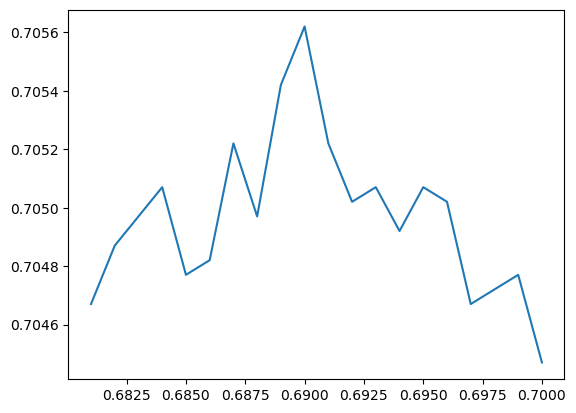

In [19]:
plt.plot(pths, accus)

In [20]:
bestpth = pths[accus.index(max(accus))]
print(f"best pth = {bestpth} with accuracy {max(accus)}")

best pth = 0.69 with accuracy 0.7056205620562056


In [21]:
# generate item Ids and user id for BPR
userIDs = {}
itemIDs = {}
for user, item, _ in trainPositiveInter:
    if not user in userIDs: userIDs[user] = len(userIDs)
    if not item in itemIDs: itemIDs[item] = len(itemIDs)

In [22]:
class BPRbatch(tf.keras.Model):
    def __init__(self, K, lamb):
        
        super(BPRbatch, self).__init__()
        # Initialize variables
        self.betaU = tf.Variable(tf.random.normal([len(userIDs)],stddev=0.001))
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.gammaU = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001))
        self.gammaI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        # Regularization coefficient
        self.lamb = lamb

    # Regularizer
    def reg(self):
        return self.lamb * (tf.nn.l2_loss(self.betaI) + tf.nn.l2_loss(self.betaU) + tf.nn.l2_loss(self.gammaU) + tf.nn.l2_loss(self.gammaI))
    
    def score(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_u = tf.nn.embedding_lookup(self.betaU, u)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        x_ui = beta_u + beta_i + tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1)
        return x_ui

    def call(self, sampleU, sampleI, sampleJ):
        x_ui = self.score(sampleU, sampleI)
        x_uj = self.score(sampleU, sampleJ)
        return -tf.reduce_mean(tf.math.log(tf.math.sigmoid(x_ui - x_uj)))

In [23]:
items = list(itemIDs.keys())

In [24]:
def trainingStepBPR(model, interactions):
    Nsamples = 50000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleJ = [], [], []
        for _ in range(Nsamples):
            u,i,_ = random.choice(interactions) # positive sample
            j = random.choice(items) # negative sample
            while j in itemsPerUser[u]:
                j = random.choice(items)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleJ.append(itemIDs[j])

        loss = model(sampleU,sampleI,sampleJ)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

In [38]:
modelBPR = BPRbatch(5, 0.00001)
optimizer = tf.keras.optimizers.legacy.Adam(0.05)

random.seed(0)
loss = 1
counter = 0

while loss > 0.434:
    loss = trainingStepBPR(modelBPR, trainPositiveInter)
    if (counter % 10 == 9): print("iteration " + str(counter+1) + ", loss = " + str(loss))
    counter += 1
print(f"Trained for {counter} iterations with final loss = {loss}")

# convert to numpy for faster computation
betai = np.array(modelBPR.betaI)
betau = np.array(modelBPR.betaU)
gammai = np.array(modelBPR.gammaI)
gammau = np.array(modelBPR.gammaU)

iteration 10, loss = 0.5667663
iteration 20, loss = 0.49331567
iteration 30, loss = 0.48735017
iteration 40, loss = 0.46818182
iteration 50, loss = 0.46125227
iteration 60, loss = 0.45212814
iteration 70, loss = 0.44997102
iteration 80, loss = 0.44510224
iteration 90, loss = 0.44045034
iteration 100, loss = 0.44137967
iteration 110, loss = 0.4378162
iteration 120, loss = 0.43932867
Trained for 121 iterations with final loss = 0.4339081645011902


In [39]:
# train a regressor to find threshold
temp1 = trainInter.copy()
temp2 = validInter.copy()
temp3 = temp1 + temp2 

regressorInter = temp2

trainX = [[1,  betau[userIDs[user]] + betai[itemIDs[item]]  + np.dot( gammai[itemIDs[item]] , gammau[userIDs[user]]  ) ] for user, item, _ in regressorInter ]
trainX = np.array(trainX)
trainY = [p for _, _, p in regressorInter] ; trainY = np.array(trainY)

logreg = linear_model.LogisticRegression(fit_intercept=False, class_weight='balanced')
logreg.fit(trainX, trainY)

LogisticRegression(class_weight='balanced', fit_intercept=False)

In [40]:
def pop_predict(user, item):
    return popularity_model(user, item, bestpth)

In [41]:
def bpr_predict(user, item):
    if user in userIDs:
        x =  [ [1,  betau[userIDs[user]] + betai[itemIDs[item]]  + np.dot(gammai[itemIDs[item]] , gammau[userIDs[user]]) ] ]
        y = logreg.predict(x)
        return y.item()
    else:
        print("using pop prediction")
        return pop_predict(user, item)

In [42]:
# evalulation
yTrain = [p for _, _, p in trainInter]
yValid = [p for _, _, p in validInter]

yhat_bpr_train = [bpr_predict(user, item) for user, item, _ in progressbar( trainInter )]
yhat_bpr_valid = [bpr_predict(user, item) for user, item, _ in progressbar( validInter )]

print("Evaluation on training set")
print(f"Accuracy of BPR based: {accuracy(yTrain, yhat_bpr_train)}")
print()
print("Evaluation on validation set")
print(f"Accuracy of BPR based: {accuracy(yValid, yhat_bpr_valid)}")


100% (330000 of 330000) |################| Elapsed Time: 0:00:10 Time:  0:00:10
100% (19998 of 19998) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


Evaluation on training set
Accuracy of BPR based: 0.757030303030303

Evaluation on validation set
Accuracy of BPR based: 0.7218221822182218


In [43]:
predictions = open("predictions/predictions_Played.csv", 'w')
for l in open("predictions/pairs_Played.csv"):
    if l.startswith("userID"):
        predictions.write(l)
        continue
    u,g = l.strip().split(',')
    
    pred = bpr_predict(u, g)
    _ = predictions.write(u + ',' + g + ',' + str(pred) + '\n')

predictions.close()

using pop prediction
using pop prediction
